#**QAFKA (Quantitative Analysis of Flourescent Kinetics Algorithm)**
##**Welcome to QAFKA jupyter notebook**
**Disclaimer:**

This notebook is based on the following paper: Automated analysis of fluorescence kinetics in single-molecule localization microscopy data reveals protein stoichiometry. [link to paper](https://pubs.acs.org/doi/10.1021/acs.jpcb.1c01130)

And source code found in: https://github.com/alonsaguy/QAFKA

Please also cite this original paper when using or developing this notebook.

##**Initialize Colab Session**
###**Mount your Google Drive**
To use this notebook on the data present in your Google Drive, you need to mount your Google Drive to this notebook.

Play the cell below to mount your Google Drive and follow the link. In the new browser window, select your drive and select 'Allow', copy the code, paste into the cell and press enter. This will give Colab access to the data on the drive.

Once this is done, your data are available in the *Files* tab on the top left of notebook.


In [30]:
#@markdown ##Run this cell to connect your Google Drive to Colab

#@markdown * Click on the URL. 

#@markdown * Sign in your Google Account. 

#@markdown * Copy the authorization code. 

#@markdown * Enter the authorization code. 

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive". 

#mounts user's Google Drive to Google Colab.

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##**Intall QAFKA and dependencies**
In the next block we will import the relevant packages for QAFKA.

In [31]:
!pip install tiffcapture
!pip install torch
!pip install ipympl

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import numpy as np
import tiffcapture as tc
import os
import matplotlib.pyplot as plt
import scipy.optimize as opt
import torch
import torch.nn as nn
import torch.optim
from scipy.stats import geom, nbinom

def clean_bg_noise(data, patch_length):
    [N, H, W] = data.shape
    clean_data = np.zeros_like(data)
    half_size = int(np.floor(patch_length/2))
    for i in range(H):
        for j in range(W):
            up = np.min([H - 1, i + half_size])
            down = np.max([0, i - half_size])
            right = np.min([W - 1, j + half_size])
            left = np.max([0, j - half_size])
            clean_data[:, i, j] = data[:, i, j] - np.mean(data[:, down:up, left:right])
    print("-I- Background noise was filtered")
    return clean_data

def segment(data, threshold, window_size):
    ref_mean = np.mean(data)
    ref_std = np.std(data)

    for i in range(data.shape[0]-window_size):
        curr_mean = np.mean(data[i:i+window_size])
        curr_std = np.std(data[i:i+window_size])

        if((np.abs(curr_mean-ref_mean)/ref_mean + np.abs(curr_std-ref_std)/ref_std) < threshold):
            print("-I- Found segmentation in frame:", i)
            return i

    print("Error: could not segment, choosing frame 500 as segmentation frame")
    return 500

def calc_threshold(raw_data, max_data):
    """
        Calculating a "good" threshold fot peak detection
        :param raw_data: Tensor [image_size] of one experiment
        :return: float as the threshold.
    """
    return 2 * np.abs(np.min(raw_data)) + np.std(raw_data), 1.5 * np.abs(np.mean(np.median(max_data, axis=1), axis=1) + np.std(max_data))

def draw_circle(size, rad):
    # size should be odd
    circle = np.zeros([size, size], dtype=int)
    mid = int((size-1)/2)
    for i in range(size):
        for j in range(size):
            if((i-mid)**2 + (j-mid)**2 <= rad**2):
                circle[i, j] = 1

    return circle

def gauss2d(xy, offset, amp, x0, y0, sigma):
    # Fit patch to gaussian
    x, y = xy
    return offset + amp * np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

def Normalization(X_train, X_val, X_test):
    """
        Normalizing the data by the statistics of X_train
        :return: normalized X_train, X_val, X_test.
    """
    for i in range(X_train.shape[0]):
        X_train[i, :] /= np.sum(X_train[i])
    for i in range(X_val.shape[0]):
        X_val[i, :] /= np.sum(X_val[i])
    for i in range(X_test.shape[0]):
        X_test[i, :] /= np.sum(X_test[i])

    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    std[np.where(std == 0)] = 1
    X_train = (X_train - mean) / std
    X_val = (X_val - mean) / std
    X_test = (X_test - mean) / std

    return torch.FloatTensor(X_train), torch.FloatTensor(X_val), torch.FloatTensor(X_test)

def fit(n_blinks_hist):
    """
        Calculates the MLE for the percentage of dimers in an experiment
        :param n_blinks_hist: Tensor [numOfBIns] for the n_blinks histogram in an exp.
        :param p: Float for the bleaching probability of a cluster
        :return: alpha - the dimers percentage in the experiment.
    """
    best_alpha, best_p = -1, -1
    max_val = -np.inf
    for j in range(200, 500):
        p = j / 1000
        for i in range(101):
            alpha = i / 100
            val = 0
            for bin in range(1, len(n_blinks_hist) + 1):
                a = p * (1 - p) ** (bin-1)
                b = (bin * (p ** 2)) * (1 - p) ** (bin-1)
                val += n_blinks_hist[bin - 1] * np.log((1 - alpha) * a + alpha * b)

            if(val > max_val):
                max_val = val
                best_alpha = alpha
                best_p = p

    return best_alpha, best_p

def plot_n_blinks(n_blinks, bleach_proba):
    for i in range(n_blinks.shape[0]):
        plt.plot(n_blinks[i]/np.sum(n_blinks[i]), label='{}'.format(i))
    x1 = np.arange(geom.ppf(0.0001, bleach_proba), geom.ppf(0.9999, bleach_proba))
    x2 = np.arange(nbinom.ppf(0.0001, 2, bleach_proba), nbinom.ppf(0.9999, 2, bleach_proba))
    plt.plot(x1 - 1, geom.pmf(x1, bleach_proba), label='Monomers only')
    plt.plot(x2, nbinom.pmf(x2, 2, bleach_proba), label='Dimers only')
    plt.legend()
    plt.show()

def estimate_by_average(n_blinks_hist, bleach_proba):
    total_blinks = np.dot(n_blinks_hist, np.arange(1, 21))
    total_clusters = np.sum(n_blinks_hist)
    best_alpha = None
    best_diff = np.inf
    for i in range(101):
        alpha = i/100
        # Monomers part * Average monomers blinks + Dimers part * Average dimers blinks
        approx = ((1-alpha)*total_clusters)*((1/bleach_proba)) + \
                 (alpha*total_clusters)*((2*(1-bleach_proba)/bleach_proba)+1)
        diff = np.abs(approx - total_blinks)
        if(diff < best_diff):
            best_diff = diff
            best_alpha = alpha

    return best_alpha

def kmeans(data):
    from sklearn.manifold import TSNE
    from sklearn.cluster import KMeans
    X_embedded = TSNE(n_components=2).fit_transform(data)
    nbrs = KMeans(n_clusters=2).fit(data)
    pred = nbrs.predict(data)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=pred)
    plt.show()

def plotting(hist, p):
    hist /= np.sum(hist)
    x1 = np.arange(geom.ppf(0.0001, p), geom.ppf(0.9999, p))
    n = 2
    x2 = np.arange(nbinom.ppf(0.001, n, p), nbinom.ppf(0.999, n, p))
    plt.plot(hist, label='Experiment histogram')
    plt.plot(x2 + 1, nbinom.pmf(x2, n, p), label='Dimers histogram')
    plt.plot(x1-1, geom.pmf(x1, p), label='Monomers histogram')
    plt.xticks(np.arange(20), np.arange(1, 21))
    plt.xlabel('Number of blinks')
    plt.ylabel('Probability')
    plt.title('Monomers and dimers Nblinks model')
    plt.legend()
    plt.show()

def CoordiantionsComparison(filename, myCoordination):
    data = np.loadtxt(filename, delimiter=' ')
    col = data[:, 0] / 40200
    row = data[:, 1] / 40270
    plt.scatter(row, col)
    plt.scatter(myCoordination[:, 0]/251, myCoordination[:, 1]/257)
    plt.xlabel('x [normalized units]')
    plt.ylabel('y [normalized units]')
    plt.legend(['Tims localizations', 'My localizations'])
    plt.show()

def debug_helper(data, emitters_grid, fit, obs, center_x, center_y, fit_quality, patch_length):
    plt.gca().invert_yaxis()
    plt.subplot(221)
    plt.imshow(data)
    plt.plot(center_y, center_x, color='r', marker='x')
    plt.subplot(222)
    plt.imshow(emitters_grid)
    plt.subplot(223)
    plt.title("Quality {}".format(fit_quality))
    plt.imshow(fit.reshape([patch_length, patch_length]))
    plt.subplot(224)
    plt.title("Localization {}, {}".format(center_x, center_y))
    plt.imshow(obs.reshape([patch_length, patch_length]))
    plt.show()

def MLE(n_blinks_hist, p, d):
    """
        Calculates the MLE for the percentage of dimers in an experiment
        :param n_blinks_hist: Tensor [numOfBIns] for the n_blinks histogram in an exp.
        :param p: Float for the bleaching probability of a cluster
        :return: alpha - the dimers percentage in the experiment.
    """
    best_alpha = -1
    max_val = -np.inf

    val_vec = np.zeros(100)
    hist_vec = np.ones(int(np.sum(n_blinks_hist)))
    for i in range(len(n_blinks_hist) - 1):
        hist_vec[int(np.sum(n_blinks_hist[:i])):int(np.sum(n_blinks_hist[:i+1]))] = i + 1

    for i in range(101):
        alpha = i / 100
        val = 0
        for n in hist_vec:
            if(n > 1):
                a = p * (1 - p) ** (n - 1)
                b = (d * ((n - 1) * (p ** 2)) * (1 - p) ** (n - 2) + (1-d) * p * (1 - p) ** (n-1))
            else:
                a = p * (1 - p) ** (n - 1)
                b = (1-d) * p * (1 - p) ** (n-1)

            val += np.log((1 - alpha) * a + alpha * b)

        if(val > max_val):
            max_val = val
            best_alpha = alpha
        val_vec[i-1] = val
    plt.plot(val_vec)
    plt.title("Real dimers percentage: {}".format(best_alpha))
    plt.show()
    return best_alpha

def find_actual_dimers_percentage(m, d):
    real_percentage = 1/(((1-m)/m + 2) * d - 1)
    return real_percentage

def debug_entire_exp(Max_Data_Set, coordinates, scale_size):
    new_img = np.zeros([scale_size * Max_Data_Set[0].shape[0], scale_size * Max_Data_Set[0].shape[1]])
    for i in range(Max_Data_Set[0].shape[0] - 1):
        for j in range(Max_Data_Set[0].shape[1] - 1):
            new_img[(scale_size * i):(scale_size * (i + 1)), (scale_size * j):(scale_size * (j + 1))] = np.max(Max_Data_Set[:, i, j])
    plt.imshow(new_img)
    plt.scatter(coordinates[:, 1], coordinates[:, 0], color='r', marker='x')
    plt.show()
    
class Trainer():
    """
    A class abstracting the various tasks of training models.
    Provides methods at multiple levels of granularity:
    - Multiple epochs (fit)
    - Single epoch (train_epoch/test_epoch)
    - Single batch (train_batch/test_batch)
    """

    def __init__(self, model, loss_fn, optimizer, device='cpu'):
        """
        Initialize the trainer.
        :param model: Instance of the model to train.
        :param loss_fn: The loss function to evaluate with.
        :param optimizer: The optimizer to train with.
        :param device: torch.device to run training on (CPU or GPU).
        """
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = device
        model.to(self.device)

    def fit(self, dl_train: DataLoader, dl_test: DataLoader,
            num_epochs, early_stopping=50, print_every=1, **kw):
        """
        Trains the model for multiple epochs with a given training set,
        and calculates validation loss over a given validation set.
        :param dl_train: Dataloader for the training set.
        :param dl_test: Dataloader for the test set.
        :param num_epochs: Number of epochs to train for.
        :param early_stopping: Whether to stop training early if there is no
            test loss improvement for this number of epochs.
        :param print_every: Print progress every this number of epochs.
        :return: Train and test losses per epoch.
        """
        train_loss, val_loss = [], []
        best_loss = None
        best_model = None
        epochs_without_improvement = 0

        for epoch in range(num_epochs):
            print(f'--- EPOCH {epoch + 1}/{num_epochs} ---')

            loss = self.train_epoch(dl_train, **kw)
            train_loss.append(loss)

            loss = self.test_epoch(dl_test, **kw)
            val_loss.append(loss)

            if(epoch == 0):
                best_loss = loss
            else:
                if(loss >= best_loss):
                    epochs_without_improvement += 1
                    if(epochs_without_improvement > early_stopping):
                        print("Reached early stopping criterion")
                        self.model.load_state_dict(torch.load('best_model'))
                        break
                else:
                    epochs_without_improvement = 0
                    best_loss = loss
                    torch.save(self.model.state_dict(), 'best_model')

            if epoch % print_every == 0 or epoch == num_epochs - 1:
                print("Epoch", epoch + 1, ": Train loss =", train_loss[-1].item())
                print("Epoch", epoch + 1, ": Validation loss =", val_loss[-1].item())


    def train_epoch(self, dl_train: DataLoader, **kw):
        """
        Train once over a training set (single epoch).
        :param dl_train: DataLoader for the training set.
        :param kw: Keyword args supported by _foreach_batch.
        :return: An EpochResult for the epoch.
        """
        self.model.train()
        total_loss = 0
        cnt = 0
        for X_train, y_train in dl_train:
            self.optimizer.zero_grad()

            # Forward pass
            y_pred = self.model(X_train)

            # Compute Loss
            loss = self.loss_fn(y_pred.squeeze(), y_train)
            total_loss += loss

            # Backward pass
            loss.backward()
            self.optimizer.step()

            cnt += 1
        return total_loss / cnt

    def test_epoch(self, dl_test: DataLoader, **kw):
        """
        Evaluate model once over a test set (single epoch).
        :param dl_test: DataLoader for the test set.
        :param kw: Keyword args supported by _foreach_batch.
        :return: An EpochResult for the epoch.
        """
        self.model.eval()
        total_loss = 0
        cnt = 0
        for X_test, y_test in dl_test:
            # Forward pass
            y_pred = self.model(X_test)
            total_loss += self.loss_fn(y_pred.squeeze(), y_test)
            cnt += 1

        return total_loss / cnt

class ONE_LAYER_NET(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ONE_LAYER_NET, self).__init__()
        self.input_size = input_size
        self.hidden_size = [self.input_size] + hidden_size

        modules = []
        modules.append(torch.nn.Linear(self.hidden_size[0], 1, bias=True))
        self.net = nn.Sequential(*modules)

    def forward(self, x):
        output = self.net(x)
        return output

class SIMPLE_FC_NET(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SIMPLE_FC_NET, self).__init__()
        self.input_size = input_size
        self.hidden_size = [self.input_size] + hidden_size

        modules = []

        for i in range(len(self.hidden_size) - 1):
            modules.append(torch.nn.Linear(self.hidden_size[i], self.hidden_size[i+1], bias=True))
            modules.append(torch.nn.PReLU())

        modules.append(torch.nn.Linear(self.hidden_size[-1], 1))

        self.net = nn.Sequential(*modules)

    def forward(self, x):
        output = self.net(x)
        return output

class CustomNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = [self.input_size] + hidden_size

        modules = []

        for i in range(len(self.hidden_size) - 1):
            modules.append(torch.nn.Linear(self.hidden_size[i], self.hidden_size[i+1]))
            modules.append(torch.nn.PReLU())

        modules.append(torch.nn.Linear(self.hidden_size[-1], 1))

        self.net = nn.Sequential(*modules)

    def forward(self, x):
        output = self.net(x)
        return output

def BiasTrick(X_train, X_val, X_test):
    coef = 0.05
    ones = torch.ones((X_train.shape[0], 1)).type(torch.FloatTensor) * coef
    X_train = torch.cat((ones, X_train.type(torch.FloatTensor)), dim=1)
    ones = torch.ones((X_val.shape[0], 1)).type(torch.FloatTensor) * coef
    X_val = torch.cat((ones, X_val.type(torch.FloatTensor)), dim=1)
    ones = torch.ones((X_test.shape[0], 1)).type(torch.FloatTensor) * coef
    X_test = torch.cat((ones, X_test.type(torch.FloatTensor)), dim=1)
    return X_train, X_val, X_test

def CreateDataLoader(X, y, batch_size):
    """
        Creates data loader for X, y pairs
        :param X: Tensor [# of observations, numOfBins] for the observations
        :param y: Tensor [# of observations] for the predictions
        :param batch_size: Int for batch size
        :return: data loader for training/ testing routines
    """
    data_loader = torch.utils.data.DataLoader(TensorDataset(X, y), batch_size=batch_size)
    return data_loader

def CreateMaxDataSet(data, max_size, seg):
    # Divide the Data_Set into sum_size datasets summing every frame of data in each segment
    max_data = np.zeros([max_size, data.shape[1], data.shape[2]])
    divider = int(data.shape[0]/max_size)
    n = divider - seg
    max_data[0, :, :] = np.max(data[:n, :, :], axis=0)
    n = divider
    for i in range(1, max_size):
        max_data[i, :, :] = np.max(data[((i-1)*n):(i*n), :, :], axis=0)
    return max_data

def LocalizeEmitters(data, sum_threshold, quality_threshold, pixel_length, resolution_nm, emitters_size):
    total_frames, max_row, max_col = data.shape
    emitters_grid = np.zeros((int(max_row * pixel_length / resolution_nm),
                              int(max_col * pixel_length / resolution_nm)), dtype=int)
    emitters_coordinates = []
    emitters_cnt = 0

    patch_length = 9  # Determine the patch we are going to fit to be of size [patch_length x patch length]
    xy = np.zeros([2, int(patch_length ** 2)])
    for i1 in range(patch_length):
        for j1 in range(patch_length):
            xy[:, int(i1 * patch_length + j1)] = [i1, j1]

    # Create the shape of a circle for the emitters grid
    circle = draw_circle(size=int(patch_length * pixel_length / resolution_nm),
                         rad=int(emitters_size / resolution_nm))

    low_intensity, bad_fit, out_of_bound = 0, 0, 0
    for frame in range(total_frames):
        img_arr = data[frame, :, :]
        threshold = sum_threshold[frame]
        if (np.max(img_arr) > threshold):
            potential_peaks = np.where(img_arr > threshold)
            for i in range(len(potential_peaks[0])):
                row, col = potential_peaks[0][i], potential_peaks[1][i]

                # Handle clusters in case of exceeding image shape
                up = int(row + np.floor(patch_length / 2)) + 1
                down = int(row - np.floor(patch_length / 2))
                left = int(col - np.floor(patch_length / 2))
                right = int(col + np.floor(patch_length / 2)) + 1

                # Ignore out of bound blinks
                if up > max_row or down < 0 or left < 0 or right > max_col:
                    out_of_bound += 1
                    continue

                # Initial guess
                x0, y0 = int(np.floor(patch_length / 2)), int(np.floor(patch_length / 2))

                # Fit the patch to a gaussian
                zobs = (img_arr[down:up, left:right]).reshape(1, -1).squeeze()

                # Check if localization is in local maximum
                if ([down + int(np.argmax(zobs)/patch_length), left + np.argmax(zobs) % patch_length] != [row, col]):
                    continue

                guess = [np.median(img_arr), np.max(img_arr) - np.min(img_arr), x0, y0, 1]
                try:
                    pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)
                except:
                    continue

                fit = gauss2d(xy, *pred_params)

                # If the peak is higher than threshold proceed
                curr_row = int(np.round(down + pred_params[3]))
                curr_col = int(np.round(left + pred_params[2]))
                if (curr_col >= max_col or curr_col < 0 or curr_row >= max_row or curr_row < 0):
                    out_of_bound += 1
                    continue

                # Handle same coordinate repetition
                y = down + pred_params[3]
                x = left + pred_params[2]
                center_y = int(np.round(y * pixel_length / resolution_nm))
                center_x = int(np.round(x * pixel_length / resolution_nm))

                if (img_arr[curr_row, curr_col] > threshold):
                    # Calculate RMS
                    zobs /= np.max(zobs)
                    fit /= np.max(fit)
                    fit_quality = 1 - np.sqrt(np.mean((zobs - fit) ** 2))

                    # If the fit quality is higher than Value > take the mean value as a new cluster's coordinates
                    # Ignore fitted gaussian with sigma higher than 1 or lower than 0.3
                    #if (fit_quality > quality_threshold and pred_params[4] < 1 and pred_params[4] > 0.3):
                    if (fit_quality > quality_threshold):
                        # If the current pixel in the grid is already tagged for one of the emitters
                        if (emitters_grid[center_y, center_x] > 0):
                            continue

                        mid = int((patch_length * pixel_length / resolution_nm)/2)
                        # If the emitter is located outside the image boundaries ignore
                        if(center_y - mid < 0 or center_y + mid + 1 >= emitters_grid.shape[0] or
                                center_x - mid < 0 or center_x + mid + 1 >= emitters_grid.shape[1]):
                            continue

                        # Add localization
                        emitters_cnt += 1
                        # Update emitters_grid
                        emitters_grid[(center_y-mid):(center_y+mid+1), (center_x-mid):(center_x+mid+1)] += emitters_cnt * circle
                        # Update emitters list
                        emitters_coordinates.append([center_y, center_x])
                    else:
                        bad_fit += 1
                else:
                    low_intensity += 1

    print("Emitter is out of bound:", out_of_bound)
    print("Bad fitting grade:", bad_fit)
    print("Emitters intensity is too low:", low_intensity)
    print("-I- found", emitters_cnt, "emitters")

    return np.array(emitters_coordinates)

def ExtractTimeTraces(raw_data, emitters_coord, pixel_length, resolution_nm, quality_threshold, threshold, emitters_size):
    total_frames, max_row, max_col = raw_data.shape
    emitters = np.zeros([emitters_coord.shape[0], total_frames])
    emitters_size_pix = emitters_size / resolution_nm
    patch_length = 5 # Determine the patch we are going to fit to be of size [patch_length x patch length]
    xy = np.zeros([2, int(patch_length ** 2)])
    for i1 in range(patch_length):
        for j1 in range(patch_length):
            xy[:, int(i1 * patch_length + j1)] = [i1, j1]

    low_intensity, bad_fit, out_of_bound, far_from_emitters = 0, 0, 0, 0
    for frame in range(total_frames):
        img_arr = raw_data[frame, :, :]
        if (np.max(img_arr) > threshold):
            potential_peaks = np.where(img_arr > threshold)
            for i in range(len(potential_peaks[0])):
                row, col = potential_peaks[0][i], potential_peaks[1][i]

                # Handle clusters in case of exceeding image shape
                up = int(row + np.floor(patch_length / 2)) + 1
                down = int(row - np.floor(patch_length / 2))
                left = int(col - np.floor(patch_length / 2))
                right = int(col + np.floor(patch_length / 2)) + 1

                # Ignore out of bound blinks
                if up > max_row or down < 0 or left < 0 or right > max_col:
                    out_of_bound += 1
                    continue

                # Initial guess
                x0, y0 = int(np.floor(patch_length / 2)), int(np.floor(patch_length / 2))

                zobs = (img_arr[down:up, left:right]).reshape(1, -1).squeeze()
                guess = [np.median(img_arr), np.max(img_arr) - np.min(img_arr), x0, y0, 1]
                try:
                    pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)
                except:
                    continue

                fit = gauss2d(xy, *pred_params)

                # Check if localization is in local maximum
                if (np.argmax(zobs) != int(np.round(pred_params[2])) * patch_length + int(np.round(pred_params[3]))):
                    continue

                # If the peak is higher than threshold proceed
                curr_row = int(np.round(down + pred_params[3]))
                curr_col = int(np.round(left + pred_params[2]))
                if (curr_col >= max_col or curr_col < 0 or curr_row >= max_row or curr_row < 0):
                    out_of_bound += 1
                    continue

                # Handle same coordinate repetition
                x = left + pred_params[2]
                y = down + pred_params[3]
                center_y = int(np.round(y * (pixel_length / resolution_nm)))
                center_x = int(np.round(x * (pixel_length / resolution_nm)))

                if (img_arr[curr_row, curr_col] > threshold):
                    # Calculate RMS
                    zobs /= np.max(zobs)
                    fit /= np.max(fit)
                    fit_quality = 1 - np.sqrt(np.mean((zobs - fit) ** 2))

                    # If the fit quality is higher than Value > take the mean value as a new cluster's coordinates
                    if (fit_quality > quality_threshold):
                        min_dist = np.inf
                        cluster_ind = -1
                        for k in range(emitters_coord.shape[0]):
                            dist = np.sqrt((center_y - emitters_coord[k, 0])**2 + (center_x - emitters_coord[k, 1])**2)
                            if (dist > emitters_size_pix):
                                continue
                            if (dist < min_dist):
                                min_dist = dist
                                cluster_ind = k
                        if (min_dist > emitters_size_pix):
                            far_from_emitters += 1
                            continue
                        else:
                            # Update emitters list with new time trace
                            emitters[cluster_ind, frame] = pred_params[0] + pred_params[1]  # Offset + Amp of gaussian
                    else:
                        bad_fit += 1
                else:
                    low_intensity += 1

    print("Blink too far from emitters:", far_from_emitters)
    print("Emitter is out of bound:", out_of_bound)
    print("Bad fitting grade:", bad_fit)
    print("Emitters intensity is too low:", low_intensity)
    print("-I- updated emitters time traces")

    return emitters

def CreateDataSet(file, chop):
    """
        Creates trajectories data set out of experimental data
        :param path: String for the path to the data library
        :param path: List for start frame and stop frame of the TIFF videos
        :return: data set [# of trajectories, trajectories length].
    """
    path = 'D:\Project\data'
    tiff = tc.opentiff(os.path.join(path, file))
    if chop[0] > tiff.length or chop[1] > tiff.length:
      print("Specified end_frame is bigger than the stack size")
      return -1
    x0 = tiff.find_and_read(chop[0])

    data = np.zeros((chop[1] - chop[0], x0.shape[0], x0.shape[1]))
    for i in range(chop[1] - chop[0]):
        data[i, :, :] = tiff.find_and_read(chop[0] + i)

    return data

def find_trajectories_gauss(raw_data, threshold, quality_threshold):
    """
        Finds trajectories from the given TIFF video
        :param raw_data: Tensor [# of trajectories, trajectories length]
        :param threshold: Float for the minimal threshold for peak detection
        :return: List of all the different trajectories in time.
    """
    total_frames, max_row, max_col = raw_data.shape
    resolution_nm = 20
    emitters_size = 8 # value * resolution_nm is the radius
    emitters_grid = np.zeros((int(max_row * 100 / resolution_nm), int(max_col * 100 / resolution_nm)), dtype=int)
    emitters_coordinates = []
    emitters = []
    emitters_cnt = 0

    patch_length = 9 # Determine the patch we are going to fit to be of size [patch_length x patch length]
    xy = np.zeros([2, int(patch_length ** 2)])
    for i1 in range(patch_length):
        for j1 in range(patch_length):
            xy[:, int(i1 * patch_length + j1)] = [i1, j1]

    # Fit patch to gaussian
    def gauss2d(xy, offset, amp, x0, y0, sigma):
        x, y = xy
        return offset + amp * np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

    for frame in range(total_frames):
        img_arr = raw_data[frame, :, :]
        if (np.max(img_arr) > threshold):
            potential_peaks = np.where(img_arr > threshold)
            for i in range(len(potential_peaks[0])):
                row, col = potential_peaks[0][i], potential_peaks[1][i]

                # Handle clusters in case of exceeding image shape
                up = int(row + np.floor(patch_length / 2)) + 1
                down = int(row - np.floor(patch_length / 2))
                left = int(col - np.floor(patch_length / 2))
                right = int(col + np.floor(patch_length / 2)) + 1

                # Ignore out of bound blinks
                if up > max_row or down < 0 or left < 0 or right > max_col:
                    continue

                # Ignore 1 pixel fake blinks
                pixel_cnt = np.where(img_arr[down:up, left:right] > threshold)[0]
                if (len(pixel_cnt) < 2):
                    continue

                # Initial guess
                x0, y0 = int(np.floor(patch_length/2)), int(np.floor(patch_length/2))

                zobs = (img_arr[down:up, left:right]).reshape(1, -1).squeeze()
                guess = [np.median(img_arr), np.max(img_arr) - np.min(img_arr), x0, y0, 1]
                try:
                    pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)
                except:
                    continue

                fit = gauss2d(xy, *pred_params)

                # Check if the gaussian's variance is too small or too big
                if(pred_params[4] < 0.5 or pred_params[4] > 1.5):
                    continue

                # Taken from H. Flyvbjerg, et al. (2010) "Optimized localization analysis for single-molecule tracking and super-resolution microscopy"
                '''sigma = pred_params[4] # Fitted sigma of the gaussian
                a_squared = 1 # Pixel size
                b_squared = 100/(patch_length ** 2) # Background's expected photons per pixel
                N = 1 # Number of photons in a spot
                sigma_a_squared = (sigma ** 2) + a_squared / 12
                Variance = (sigma_a_squared / N) * (16/9 + (8*np.pi*sigma_a_squared*b_squared)/(N*a_squared))'''

                # If the peak is higher than threshold proceed
                curr_row = int(down + pred_params[3])
                curr_col = int(left + pred_params[2])
                if(curr_col > max_col or curr_col < 0 or curr_row > max_row or curr_row < 0):
                    continue

                # Handle same coordinate repetition
                x = left + pred_params[2]
                y = down + pred_params[3]
                center_y = int(y * 100 / resolution_nm)
                center_x = int(x * 100 / resolution_nm)

                if (img_arr[curr_row, curr_col] > threshold):
                    # Calculate RMS
                    zobs /= np.max(zobs)
                    fit /= np.max(fit)
                    fit_quality = 1 - np.sqrt(np.mean((zobs - fit) ** 2))

                    # If the fit quality is higher than Value > take the mean value as a new cluster's coordinates
                    if (fit_quality > quality_threshold):

                        # If the current pixel in the grid is already tagged for one of the emitters
                        if(emitters_grid[center_y, center_x] > 0):
                            # If the current blink has already been discovered
                            if (emitters[emitters_grid[center_y, center_x] - 1][frame] > 0):
                                continue
                            else:
                                # Update emitters_grid
                                emitters_grid[center_y - emitters_size:center_y + emitters_size,
                                              center_x - emitters_size:center_x + emitters_size] = emitters_grid[center_y, center_x]
                                # Update emitters list
                                emitters[emitters_grid[center_y, center_x] - 1][frame] = pred_params[0] + pred_params[1]
                                continue

                        # Add localization
                        emitters_cnt += 1
                        # Update emitters_grid
                        emitters_grid[center_y-emitters_size:center_y+emitters_size,
                                      center_x-emitters_size:center_x+emitters_size] = emitters_cnt
                        # Update emitters list
                        emitters_coordinates.append([y, x])
                        time_trace = np.zeros(total_frames)
                        time_trace[frame] = pred_params[0] + pred_params[1]# Offset + Amp of gaussian
                        emitters.append(time_trace)

    print("-I- found", len(emitters), "emitters")

    return np.array(emitters), np.array(emitters_coordinates)

def find_trajectories(raw_data, threshold, MaxTraceLength):
    """
        Finds trajectories from the given TIFF video
        :param raw_data: Tensor [# of trajectories, trajectories length]
        :param threshold: Float for the minimal threshold for peak detection
        :return: List of all the different trajectories in time.
    """
    dict_vec = []
    dist = 5
    total_frames, max_row, max_col = raw_data.shape

    for frame in range(total_frames):
        img_arr = raw_data[frame, :, :]
        if (np.max(img_arr) > threshold):
            potential_peaks = np.where(img_arr > threshold)

            for i in range(len(potential_peaks[0])):
                row, col = potential_peaks[0][i], potential_peaks[1][i]
                up = row + 1 if row < max_row else row
                down = row - 1 if row > 0 else row
                left = col - 1 if col > 0 else col
                right = col + 1 if col < max_col else col

                if (np.mean(img_arr[down:up+1, left:right+1]) > threshold):
                    flag = False
                    for k in range(len(dict_vec)):
                        if (row == dict_vec[k]['row'] and col == dict_vec[k]['col'] and
                                np.abs(frame - dict_vec[k]['start']) < MaxTraceLength):
                            flag = True
                            break
                        else:
                            if(np.abs(row - dict_vec[k]['row']) < dist and np.abs(col - dict_vec[k]['col']) < dist and
                                    np.abs(frame - dict_vec[k]['start']) < MaxTraceLength):
                                start = dict_vec[k]['start'] if dict_vec[k]['start'] < total_frames else total_frames - MaxTraceLength
                                rowK = dict_vec[k]['row']
                                colK = dict_vec[k]['col']
                                trace1 = raw_data[start:(start+MaxTraceLength), row, col]
                                trace2 = raw_data[start:(start+MaxTraceLength), rowK, colK]
                                corr = np.corrcoef(trace1, trace2)[0, 1]
                                if(np.abs(corr) > 0.1):
                                    flag = True
                                    break

                    if (flag == False):
                        dict = {'start': frame, 'row': row, 'col': col}
                        dict_vec.append(dict)

    N = len(dict_vec)
    trajectories_arr = np.zeros((N, MaxTraceLength))
    coordinates = np.zeros((N, 2))
    for i in range(N):
        start = dict_vec[i]['start']
        stop = dict_vec[i]['start']+MaxTraceLength
        if(stop > total_frames):
            stop = total_frames
            start = total_frames - MaxTraceLength
        trajectories_arr[i, :] = raw_data[start:stop, dict_vec[i]['row'], dict_vec[i]['col']]
        coordinates[i, 0] = dict_vec[i]['row']
        coordinates[i, 1] = dict_vec[i]['col']

    print("-I- found", N, "time traces")
    return trajectories_arr, coordinates

def feature_extraction(trajectories, threshold, numOfBins):
    """
        Extracting n_blinks features according to the given trajectories
        :param trajectories: List of trajectories
        :param threshold: Float for minimal threshold for peak detection
        :param numOfBins: Int for the range of the n_blinks histogram
        :param tau: Int for the tau_c parameter
        :return: Tensor [1, numOfBins] for the n_blinks histogram of the experiment.
    """
    L = len(trajectories)
    features = np.zeros((L, numOfBins))
    n_blinks_per_cluster = []
    for i in range(L):
        numOfTrajectories, TrajectoryLength = trajectories[i].shape
        for trajectory in range(numOfTrajectories):
            n_blinks = 0
            frame = 0
            while(frame < TrajectoryLength):
                if(trajectories[i][trajectory, frame] >= threshold):
                    n_blinks += 1
                    start_time = frame + 10
                    while (trajectories[i][trajectory, frame] >= threshold and frame < start_time):
                        frame += 1
                        if (frame > TrajectoryLength - 1):
                            break
                else:
                    if(trajectories[i][trajectory, frame] < threshold/2):
                        while (trajectories[i][trajectory, frame] < threshold):
                            frame += 1
                            if (frame > TrajectoryLength - 1):
                                break
                    else:
                        frame += 1

            if (n_blinks > 0 and n_blinks < numOfBins):
                features[i, n_blinks - 1] += 1
                n_blinks_per_cluster.append(n_blinks)
            else:
                n_blinks_per_cluster.append(0)

    np.save('X_test', features)
    return features,  np.expand_dims(np.array(n_blinks_per_cluster), axis=1)

def LoadFinalDataSet():
    """
        Loads an existing data set after feature extraction
        :return: data set [# of experiments, numOfBins].
    """
    data_set = np.load('X_test.npy')
    return data_set

def CreateSimulatedDataSet_special():
    path = 'D:\Project\data'
    files = [r'CTLA4/mEos3.2.tif', r'CTLA4/mEos3.2_X2.tif']
    data = np.zeros((24000, 251, 257))

    for j in range(2):
        tiff = tc.opentiff(os.path.join(path, files[j]))
        for i in range(12000):
            data[int(12000*j + i), :, :] = tiff.find_and_read(i)

    return data

def CreateSimulatedDataSet(data_set_size, num_of_molecules, bleach_proba, numOfBins):
    """
        Creates many simulations of features based on ground truth
        :param data_set_size: Int for the number of simulations to perform
        :param num_of_molecules: Int for the number of molecules to simulate per simulations
        :param bleac_proba: Float for the bleaching probability of single cluster
        :param numOfBins: Int for the range of the n_blinks histogram
        :return: data_set [data_set_size, numOfBins] for the entire simulated data set.
    """
    X = np.zeros([data_set_size, numOfBins])
    y = np.zeros(data_set_size)

    for i in range(data_set_size):
        if(np.random.rand() > 0.4): # Creating more monomers only experiments
            y[i] = 0 # Monomers only
        else:
            y[i] = np.random.rand() # Random dimers percentage

        MonoList = []
        for j in range(int(num_of_molecules - num_of_molecules * y[i])): # MONOMERS
            MonoCnt = 1 # Always start with one blink
            while(np.random.rand() > bleach_proba): # add blinks until bleaches
                MonoCnt += 1
            MonoList.append(MonoCnt)
        DimersList = []
        for j in range(int(num_of_molecules - num_of_molecules * y[i]), num_of_molecules): # DIMERS
            DimersCnt = 2 # Always start with two blinks
            while(np.random.rand() > bleach_proba): # add blinks until bleaches
                DimersCnt += 1
            while (np.random.rand() > bleach_proba): # dimers bleach twice
                DimersCnt += 1
            DimersList.append(DimersCnt)

        Nblinks_mono = np.histogram(np.array(MonoList) - 1, bins=numOfBins, range=(0, numOfBins))[0]
        Nblinks_dimers = np.histogram(np.array(DimersList) - 1, bins=numOfBins, range=(0, numOfBins))[0]

        X[i, :] = Nblinks_mono + Nblinks_dimers

    np.save('X', X)
    np.save('y', y)
    return X, y

def LoadSimulatedDataSet_special():
    """
        Loads an existing trajectories list
        :return: List of trajectories.
    """
    X = np.load('X_special.npy')
    y = np.load('y_special.npy')
    return X, y

def LoadSimulatedDataSet():
    """
        Loads an existing trajectories list
        :return: List of trajectories.
    """
    X = np.load('X.npy')
    y = np.load('y.npy')
    return X, y

def Filter_beads(data):
    mean_intensity = np.mean(data)
    std_intensity = np.std(data)
    bids_loc = np.where(np.mean(data, axis=0) > mean_intensity * 1.1)
    data[:, bids_loc[0], bids_loc[1]] = np.random.normal(mean_intensity, std_intensity, [data.shape[0], len(bids_loc[0])])
    return data
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print("Packages installation completed successfully")

Packages installation completed successfully


##**Parameter Initiallization**
Now you should specify some important parameters for your run.

**numOfBins** - Specifies the number of bins in the histogram of the number of blinking events (default: 20)

**start/end_frame** - Specifies which frames of the experiment you would like to analyze. For example: start_frame = 0 and end_frame=1000 will cause QAFKA to analyze the experiment between the first frame and the 1000th frame.

**pixel_length** - Specifies the experiment's pixel size [nm]

**scale_size** - Specifies the resolution scaling. For example: scale_size = 3 and pixel_length = 150 [nm] would results in a reconstrcuted image with grid size of 50 [nm].

**emitters_size** - Specifies the emitters merging radius for detection. If two clusters would be located within this radius they would be considered as a single cluster.

**numOfClusters** - Specifies the number of simulated clusters in each simulated experiment

**file_name** - Specifies the name of the TIFF file . For example: 'my_exp.tif'.

**qualityThreshold** - Specifies the minimal fitting score for the localization block. (default: 0.85)

In [32]:
numOfBins = 20 #@param {type:"number"}
start_frame = 0 #@param {type:"number"}
end_frame = 5000 #@param {type:"number"}
pixel_length = 157# @param {type:"number"}
scale_size = 3 #@param {type:"number"}
merging_radius = 150 #@param {type:"number"}
file_name = '/content/gdrive/MyDrive/QAFKA test/test_vid.tif' #@param {type:"string"}
qualityThreshold = 0.85 #@param {type:"number"}
chop = [start_frame, end_frame]

##**Run Configuration**
**LoadData** - Determines if we want to load new experimental data (True) or we want to use an already loaded data (False).

**FilterBeads** - Determines if an additional beads filtration algorithm is needed for the experimental data.

**CreateSimulatedData** - Determines if we want to use the same training data as before (True) or we want to create new training set (False).

**TrainNet** - Determines if we want to train the neural network (True) or not (False). Usually it takes ~5 minutes to train the network.

**preTrainedModel** - Specifies the pre-trained model to load in case we do not want to train the net.

In [33]:
LoadData = True #@param {type:"boolean"}
FilterBeads = False #@param {type:"boolean"}
CreateSimulatedData = True #@param {type:"boolean"}
TrainNet = True #@param {type:"boolean"}
preTrainedModel = 'model_final_gauss' #@param {type:"string"}

##**Analysis Pipeline**
Run this block to analyze the provided tiff stacks and generate number of blinking events histograms per experiment.

In [34]:
if(chop[1]-chop[0]<2000):
    max_size = int((chop[1]-chop[0])/500)
else:
    max_size = int((chop[1]-chop[0])/1000)
    
resolution_nm = pixel_length/scale_size #[nm]

if(LoadData):
    trajectories, clusterCoordinations = [], []
    print("**** Analyzing Tiff file ****")
    # Load TIFF files and create data_set
    Data_Set = CreateDataSet(file_name, chop)
    if np.all(Data_Set != -1): 
      # Segment the experiment before and after laser activation
      seg = segment(Data_Set, threshold=0.15, window_size=100)
      
      # Filter beads (if True)
      if(FilterBeads):
          Data_Set = Filter_beads(Data_Set)
      
      # Background noise cleaning
      Data_Set = clean_bg_noise(Data_Set, patch_length=5)
      
      # Clusters localization
      Max_Data_Set = CreateMaxDataSet(Data_Set, max_size, seg)
      DataThreshold, MaxThreshold = calc_threshold(Data_Set, Max_Data_Set)
      coordinates = LocalizeEmitters(Max_Data_Set, MaxThreshold, qualityThreshold, pixel_length, resolution_nm, merging_radius)
      
      # Create time traces for each cluster
      timeTraces = ExtractTimeTraces(Data_Set[seg:, :, :], coordinates, pixel_length, resolution_nm, qualityThreshold, DataThreshold, merging_radius)
      
      # Save the time traces and clusters locations of all experiments in a list
      trajectories.append(timeTraces)
      clusterCoordinations.append(coordinates)
      
      # The coordinations file would be saved as 'coordinated.npy'
      np.save('clusterCoordinations', clusterCoordinations)

      # Extract the features that would serve as the neural network's input
      X_test, n_blink_per_cluster = feature_extraction(trajectories, DataThreshold, numOfBins)
      num_of_blinks_per_cluster = np.concatenate([pixel_length*clusterCoordinations[0]/scale_size, n_blink_per_cluster], axis=1)
      np.save('num_of_blinks_per_cluster', num_of_blinks_per_cluster)
      print("Experimental Data was loaded successfully")
    else:
      print("Experimental Data was not loaded")
else:
    # Load features of an already analyzed experiment
    X_test = LoadFinalDataSet()
    print("Experimental Data was loaded successfully")



**** Analyzing Tiff file ****
-I- Found segmentation in frame: 0
-I- Background noise was filtered


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Emitter is out of bound: 40
Bad fitting grade: 0
Emitters intensity is too low: 4
-I- found 80 emitters
Blink too far from emitters: 672
Emitter is out of bound: 81
Bad fitting grade: 12
Emitters intensity is too low: 791
-I- updated emitters time traces
Experimental Data was loaded successfully


##**Plot Histograms**

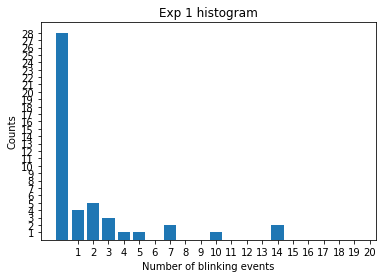

In [35]:
%matplotlib inline

for i in range(X_test.shape[0]):
    plt.figure()
    plt.bar(np.arange(numOfBins), X_test[i])
    plt.xlabel('Number of blinking events')
    plt.ylabel('Counts')
    plt.xticks(np.arange(1, numOfBins + 1))
    plt.yticks(np.arange(1, np.max(X_test[i]) + 1))
    plt.title("Exp " + str(i+1) + " histogram")
    plt.show()

##**Export to Excel**


In [36]:
export_dir = '/content/gdrive/MyDrive/QAFKA test' #@param {type:"string"}

np.savetxt(os.path.join(export_dir, "Exp_histogram.csv"), X_test[0], delimiter=',')
np.savetxt(os.path.join(export_dir, "Exp_localization.csv"), num_of_blinks_per_cluster, delimiter=',')

print("Data export completed successfully")

Data export completed successfully


##**Visualize Localizations**
The next block will plot a max projection image of the last experiment with the localization marked on it.

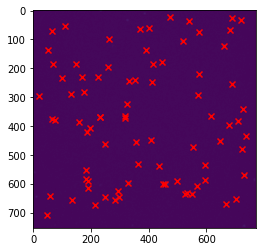

In [29]:
if(LoadData):
    debug_entire_exp(Max_Data_Set, coordinates, scale_size)

##**Data Simulation Configuration**
If you chose to simulate the training data, you would need to specify the following parameters:

**numOfClusters** - Specifies the number of simulated clusters in each simulation (relevant only if CreateSimulatedData is set to True).

**bleach_proba** - Specifies the bleaching probability [0, 1] of the used fluorophore.

**TrainSetSize** - Specifies the number of simulated experiments to be created.

In [ ]:
numOfClusters = 200 #@param {type:"number"}
bleach_proba = 0.41 #@param {type:"number"}
TrainSetSize = 10000 #@param {type:"number"}

##**Create Simulated Training Data**


In [ ]:
if(CreateSimulatedData):
    [X, y] = CreateSimulatedDataSet(TrainSetSize, numOfClusters, bleach_proba, numOfBins)
else:
    [X, y] = LoadSimulatedDataSet()

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75)
[X_train, X_val, X_test] = Normalization(X_train, X_val, X_test)
[X_train, X_val, X_test] = BiasTrick(X_train, X_val, X_test)
y_train = torch.FloatTensor(y_train)
y_val = torch.FloatTensor(y_val)

print("-I- Simulated Data was created successfully")

-I- Simulated Data was created successfully


##**Build Model**
In the next block we will build the neural network model.

**lr** - Specifies the training phase learning rate.

**betas** - Specifies the parameters for ADAM optimizer.

**batch_size** - Specifies the batch size of the training phase.

**epochs** - Specifies the maximal training epoch.

**early_stopping** - Specifies the tolerance of the neural network to lack of improvement in the validation loss. For example: early_stopping = 5, would stop the trainig phase if the validation loss did not improve for 5 epochs.

In [ ]:
lr = 1e-5 #@param {type:"number"}
betas = (0.99, 0.999) 
batch_size = 4 #@param {type:"number"}
epochs = 1000 #@param {type:"number"}
early_stopping = np.min((int(epochs/5), 15))

##**Training Phase**


In [ ]:
if(TrainNet):
    model = CustomNet(torch.numel(X_train[0]), [128, 128, 128, 128])
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

    dl_train = CreateDataLoader(X_train, y_train, batch_size=batch_size)
    dl_val = CreateDataLoader(X_val, y_val, batch_size=1)

    # ================= Train Net ================
    trainer = Trainer(model, criterion, optimizer)
    trainer.fit(dl_train, dl_val, num_epochs=epochs, early_stopping=early_stopping, print_every=1)
    torch.save(trainer.model.state_dict(), 'model_final_gauss')

--- EPOCH 1/1000 ---


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 : Train loss = 0.03212399780750275
Epoch 1 : Validation loss = 0.003462279913946986
--- EPOCH 2/1000 ---
Epoch 2 : Train loss = 0.0027356205973774195
Epoch 2 : Validation loss = 0.0019887913949787617
--- EPOCH 3/1000 ---
Epoch 3 : Train loss = 0.0019534851890057325
Epoch 3 : Validation loss = 0.0016596938949078321
--- EPOCH 4/1000 ---
Epoch 4 : Train loss = 0.001691129757091403
Epoch 4 : Validation loss = 0.0014942786656320095
--- EPOCH 5/1000 ---
Epoch 5 : Train loss = 0.0015532984398305416
Epoch 5 : Validation loss = 0.0014030958991497755
--- EPOCH 6/1000 ---
Epoch 6 : Train loss = 0.001474941847845912
Epoch 6 : Validation loss = 0.0013525292742997408
--- EPOCH 7/1000 ---
Epoch 7 : Train loss = 0.001425144961103797
Epoch 7 : Validation loss = 0.0013207215815782547
--- EPOCH 8/1000 ---
Epoch 8 : Train loss = 0.001389233162626624
Epoch 8 : Validation loss = 0.0012992472620680928
--- EPOCH 9/1000 ---
Epoch 9 : Train loss = 0.0013611987233161926
Epoch 9 : Validation loss = 0.0012

##**Load Pre-trained Model**


In [ ]:
model = CustomNet(torch.numel(X_train[0]), [128, 128, 128, 128])
model.load_state_dict(torch.load(preTrainedModel))
print("Pretrained model loaded successfully")

##**Testing Phase**

In [ ]:
y_val_pred = model(X_val)
y_test_pred = model(X_test).squeeze()
y_test_pred = torch.max(y_test_pred, torch.zeros(y_test_pred.shape))

val_acc = torch.mean(torch.abs(y_val_pred.squeeze() - y_val))
print("Neural Network Validation MSE:", 100 * val_acc.item())

print("Printing dimer percentage per experiment:")
if(y_test_pred.shape == torch.Size([])):
    print("1: ", 100 * y_test_pred.item())
else:
    for i in range(y_test_pred.shape[0]):
        print(str(i+1)+": ", 100 * y_test_pred[i].item())

Neural Network Validation MSE: 2.058623358607292
Printing dimer percentage per experiment:
1:  70.13059854507446


##**Detection Efficiency Correction**
Please specify the detection efficiency in your experiment. It should be a number in the range [0,1].

In [ ]:
detection_efficiency = 0.78 #@param {type:"number"}


###**Calculate Final Predictions**

In [ ]:
print("Printing corrected dimer percentage per experiment:")
if(y_test_pred.shape == torch.Size([])):
    print("1: ", 100 * find_actual_dimers_percentage(y_test_pred.item(), detection_efficiency))
else:
    for i in range(y_test_pred.shape[0]):
         print(str(i+1)+": ", 100 * find_actual_dimers_percentage(y_test_pred[i].item(), detection_efficiency))

Printing corrected dimer percentage per experiment:
1:  112.08115230511399
